In [1]:
# from ipynb.fs.full.pipeline import WeatherForecastingPipeline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from ipynb.fs.full.plotter_class import Plotter
from ipynb.fs.full.time_series_data import TimeSeriesData
from ipynb.fs.full.dataset_creator import SupervisedDatasetCreator
from ipynb.fs.full.dataset_scaler_manager import DataScalerManager
from ipynb.fs.full.lstm import LSTMModel

In [3]:
class WeatherForecastingPipeline:
    def __init__(self, config):
        self.config = config
        # self.plotter = Plotter()
        self.data_scaler_manager = DataScalerManager()
        self.lstm_model = None
        self.scaler = None
        self.data = None
        self.y_test_pred = None
        
    def create_supervised_data(self):
        preprocessor = SupervisedDatasetCreator(self.config['input_length'], self.config['output_length'])
        x_train, y_train = preprocessor.create_supervised_dataset(self.data['train'].values)
        x_val, y_val = preprocessor.create_supervised_dataset(self.data['val'].values)
        x_test, y_test = preprocessor.create_supervised_dataset(self.data['test'].values)

        self.data.update({
            'x_train': x_train, 'y_train': y_train,
            'x_val': x_val, 'y_val': y_val,
            'x_test': x_test, 'y_test': y_test
        })
                                
    def build_model(self):
        input_shape = (self.data['x_train'].shape[1], self.data['x_train'].shape[2])
        lstm_model = LSTMModel(n_units=self.config['n_units'], input_shape=input_shape, output_shape=self.config['output_length'], learning_rate=self.config['learning_rate'])
        self.lstm_model = lstm_model.model
        
    def evaluate_model(self):
        rmse_train = self.lstm_model.evaluate(self.data['x_train'], self.data['y_train'], verbose=0)
        rmse_val = self.lstm_model.evaluate(self.data['x_val'], self.data['y_val'], verbose=0)
        rmse_test = self.lstm_model.evaluate(self.data['x_test'], self.data['y_test'], verbose=0)

        print('RMSE Comparison:')
        print(f'  RMSE Train: {rmse_train:.3f}')
        print(f'  RMSE Val: {rmse_val:.3f}')
        print(f'  RMSE Test: {rmse_test:.3f}')
        
    def load_data(self):
        ts_data = TimeSeriesData(self.config['data_path'], self.config['file_name'])
        series = ts_data.df[self.config['target_column']]
        train, val, test = ts_data.train_val_test_split(series)
        self.data = {'train': train, 'val': val, 'test': test}
    
    def plot_datasets(self):
        plotter = Plotter()       
         
        plotter.plot(self.data['train'], label='Train')
        plotter.plot(self.data['val'], label='Val')
        plotter.plot(self.data['test'], label='Test')
        plotter.configure(title='Weather Data', ylabel='Temperature (°C)')
        plotter.show() 
        
    # def plot_predictions(self):
    #     plotter = Plotter()
    #     plotter.plot(self.data['test'], label='True')
    #     plotter.plot(self.y_test_pred, label='Predicted')
    #     plotter.configure(title='True vs Predicted', ylabel='Temperature (°C)')
    #     plotter.show()
    
    def plot_predictions(self):
        plotter = Plotter()

        # # Calculate the length of the train and validation sets
        # train_len = len(data['train'])
        # val_len = len(data['val'])
        # test_len = len(data['test'])

        # # Create an array of indices for the test data
        # test_index = np.arange(train_len + val_len, train_len + val_len + test_len)

        plotter.plot(self.data['test'].values, label='True')  
        plotter.plot(self.y_test_pred, label='Predicted')
        plotter.configure(title='True vs Predicted', xlabel='Time Steps', ylabel='Temperature (°C)')
        plotter.show()
        
    def plot_prediction_errors(self):
        N = len(self.y_test_pred)  
        ndato = np.linspace(1, N, N)

        errores = self.data['y_test'].flatten() - self.y_test_pred
        plt.plot(ndato, errores)
        plt.xlabel('Índice de Predicción')
        plt.ylabel('Error de Predicción')
        plt.title('Errores de Predicción')
        plt.show()
        
    def plot_rmse_over_timesteps(self):
        y_test_pred_scaled = self.lstm_model.predict(self.data['x_test'], verbose=0)
        y_test_pred = self.scaler.inverse_transform(y_test_pred_scaled)

        diff_cuad = np.square(self.data['y_test'].squeeze() - y_test_pred)
        proms = np.mean(diff_cuad, axis=0)
        rmse = np.sqrt(proms)

        t = np.linspace(1, self.config['output_length'], self.config['output_length'])
        fig, ax = plt.subplots()
        ax.scatter(t, rmse)
        ax.set_xlabel('Predicted Timestep')
        ax.set_ylabel('RMSE Error (°C)')
        plt.xticks(ticks=t, labels=t)
        plt.grid()
        plt.show()    

    def plot_training_history(self, history):
        plotter = Plotter()
        
        plotter.plot(history.history['loss'], label='RMSE Train')
        plotter.plot(history.history['val_loss'], label='RMSE Val')
        plotter.configure(title='Epochs vs RMSE', xlabel='Epochs', ylabel='RMSE')
        plotter.show()        
        
    def predict(self, x):
        y_pred_scaled = self.lstm_model.predict(x, verbose=0)
        y_pred = self.scaler.inverse_transform(y_pred_scaled)
        self.y_test_pred = y_pred.flatten()
    
    def scale_data(self):
        scaled_data, self.scaler = self.data_scaler_manager.scale_data(self.data)
        self.data.update(scaled_data)
                
    def train_model(self):
        early_stopping = EarlyStopping(patience=6, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-7)

        history = self.lstm_model.fit(
            self.data['x_train'], self.data['y_train'],
            epochs=self.config['epochs'],
            batch_size=self.config['batch_size'],
            validation_data=(self.data['x_val'], self.data['y_val']),
            callbacks=[early_stopping, reduce_lr],
            verbose=2
        )

        self.plot_training_history(history)
        
    def run(self):
        self.load_data()
        self.plot_datasets()
        self.create_supervised_data()
        self.scale_data()
        self.build_model()
        self.train_model()
        self.evaluate_model()
        self.predict(self.data['x_test'])
        self.plot_predictions()
        self.plot_prediction_errors()
        if self.config['output_length'] > 1:
            self.plot_rmse_over_timesteps()

In [4]:
# Configuration dictionary
config = {
    'data_path': './../data',
    'file_name': 'weather_dataset_preprocesado.csv',
    'target_column': 'T (degC)',
    'input_length': 24,
    'output_length': 1,
    'epochs': 20,
    'batch_size': 256,
    'learning_rate': 2.8e-4,
    'n_units': 256
}

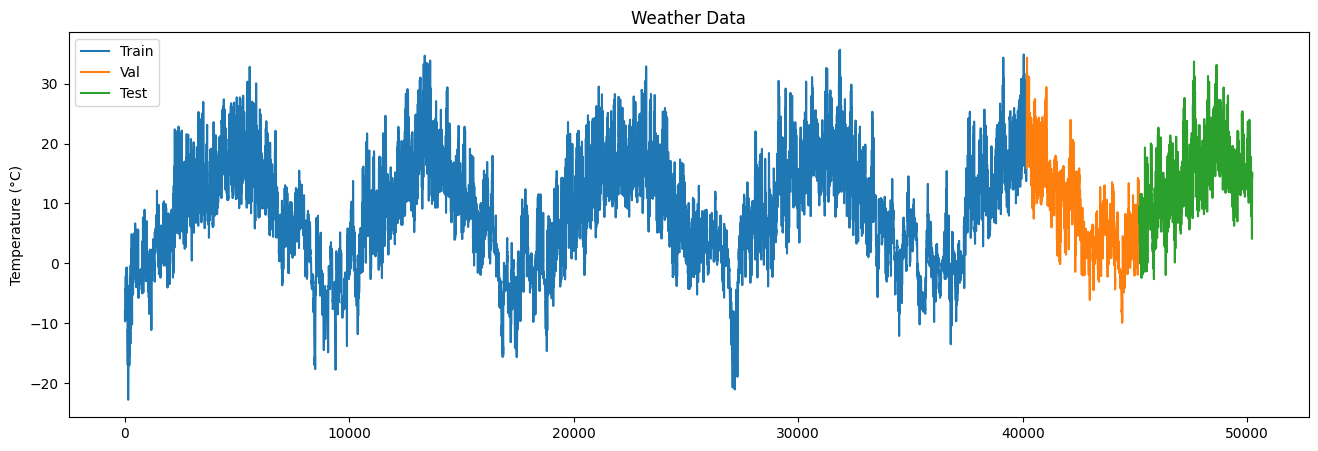

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
157/157 - 30s - 191ms/step - loss: 0.0908 - val_loss: 0.0496 - learning_rate: 2.8000e-04
Epoch 2/20
157/157 - 32s - 202ms/step - loss: 0.0506 - val_loss: 0.0395 - learning_rate: 2.8000e-04
Epoch 3/20
157/157 - 31s - 198ms/step - loss: 0.0426 - val_loss: 0.0326 - learning_rate: 2.8000e-04
Epoch 4/20
157/157 - 32s - 207ms/step - loss: 0.0369 - val_loss: 0.0282 - learning_rate: 2.8000e-04
Epoch 5/20
157/157 - 33s - 208ms/step - loss: 0.0333 - val_loss: 0.0261 - learning_rate: 2.8000e-04
Epoch 6/20
157/157 - 31s - 200ms/step - loss: 0.0314 - val_loss: 0.0246 - learning_rate: 2.8000e-04
Epoch 7/20
157/157 - 36s - 228ms/step - loss: 0.0306 - val_loss: 0.0239 - learning_rate: 2.8000e-04
Epoch 8/20
157/157 - 29s - 184ms/step - loss: 0.0300 - val_loss: 0.0238 - learning_rate: 2.8000e-04
Epoch 9/20
157/157 - 34s - 216ms/step - loss: 0.0297 - val_loss: 0.0235 - learning_rate: 2.8000e-04
Epoch 10/20
157/157 - 33s - 210ms/step - loss: 0.0293 - val_loss: 0.0236 - learning_rate: 2.8000e-04

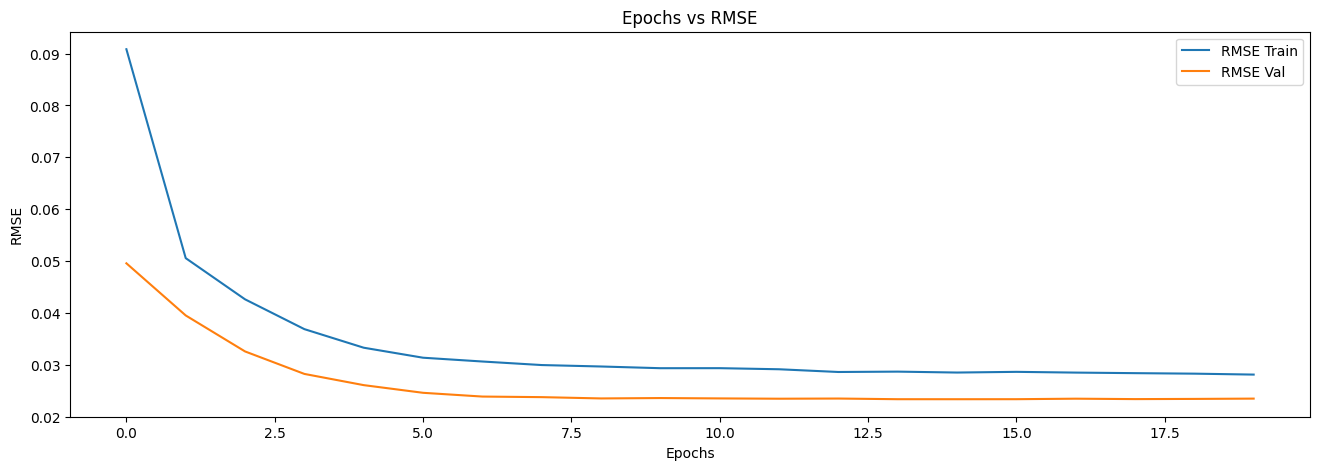

RMSE Comparison:
  RMSE Train: 0.024
  RMSE Val: 0.022
  RMSE Test: 0.027


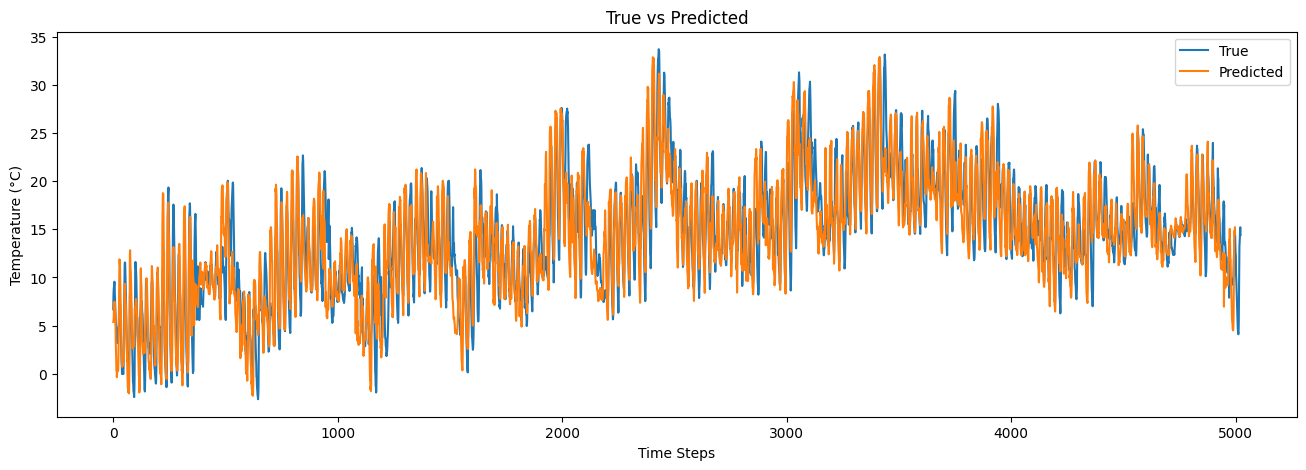

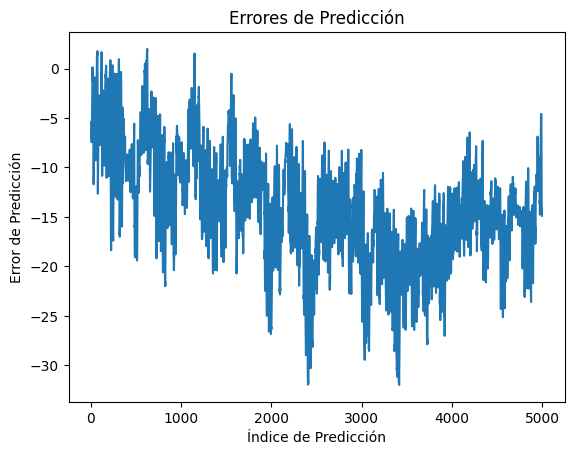

In [5]:
# Pipeline Execution
pipeline = WeatherForecastingPipeline(config)
pipeline.run()